# Create a logistic regression model to predict RIT1 mutation from gene expression data in TCGA

In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'RIT1' classifier 
GENE = '6016'# RIT1

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/RIT1) about RIT1*

## Load Data

In [4]:
%%time
path = os.path.join('..', 'download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 1min 14s, sys: 552 ms, total: 1min 14s
Wall time: 1min 14s


In [5]:
%%time
path = os.path.join('..', 'download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 41 s, sys: 424 ms, total: 41.4 s
Wall time: 41.4 s


In [6]:
y = Y[GENE]

In [7]:
# The Series now holds RIT1 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    0
TCGA-02-2483-01    0
TCGA-02-2485-01    0
TCGA-02-2486-01    0
TCGA-04-1348-01    0
Name: 6016, dtype: int64

In [8]:
# Here is the count of tumors with RIT1
y.value_counts()

0    7285
1      21
Name: 6016, dtype: int64

## Set aside 30% of the data for testing

In [9]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,530 features, 5,114 training samples, 2,192 testing samples'

In [10]:
# Here is the count of tumors with RIT1 in the testing data
y_test.value_counts()

0    2186
1       6
Name: 6016, dtype: int64

## Preprocessing and noise reduction

In [11]:
scale_pre = StandardScaler()
X_train_scale = scale_pre.fit_transform(X_train)
X_test_scale = scale_pre.transform(X_test)

In [12]:
n_components = 35
pca = PCA(n_components=n_components, random_state=0)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [13]:
# Percentage of preserved variance
print('{:.4}'.format(sum(pca.explained_variance_ratio_)))

0.5996


In [14]:
scale_post = StandardScaler()
X_train_scale = scale_post.fit_transform(X_train_pca)
X_test_scale = scale_post.transform(X_test_pca)

## Parameters and Classifier Fitting

In [15]:
param_grid = {
    'alpha': [2**x for x in range(-20, 60)],
    'l1_ratio': [0]
}

In [16]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
cv_folds = sss.split(X_train_scale, y_train)
cv_folds = [[t, c] for t, c in cv_folds]

In [17]:
%%time
clf = SGDClassifier(random_state=0, class_weight='balanced', loss='log', penalty='elasticnet')
cv = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
cv.fit(X = X_train_scale, y=y_train)

CPU times: user 840 ms, sys: 272 ms, total: 1.11 s
Wall time: 4.2 s


In [18]:
# Best Params
print('{:.3%}'.format(cv.best_score_))

# Best Params
cv.best_params_

82.601%


{'alpha': 0.5, 'l1_ratio': 0}

## Visualize hyperparameters performance

In [19]:
cv_result_df = pd.concat([
    pd.DataFrame(cv.cv_results_),
    pd.DataFrame.from_records(cv.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_l1_ratio,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,alpha,l1_ratio
0,0.015408,0.081002,0.774034,0.907252,9.53674e-07,0,"{'alpha': 9.5367431640625e-07, 'l1_ratio': 0}",62,0.731412,0.840541,0.818588,0.929921,0.772101,0.951294,0.003429,0.023156,0.035619,0.047972,9.536743e-07,0
1,0.013175,0.073070,0.773956,0.907615,1.90735e-06,0,"{'alpha': 1.9073486328125e-06, 'l1_ratio': 0}",63,0.732706,0.840688,0.817176,0.930421,0.771984,0.951735,0.001200,0.008544,0.034517,0.048117,1.907349e-06,0


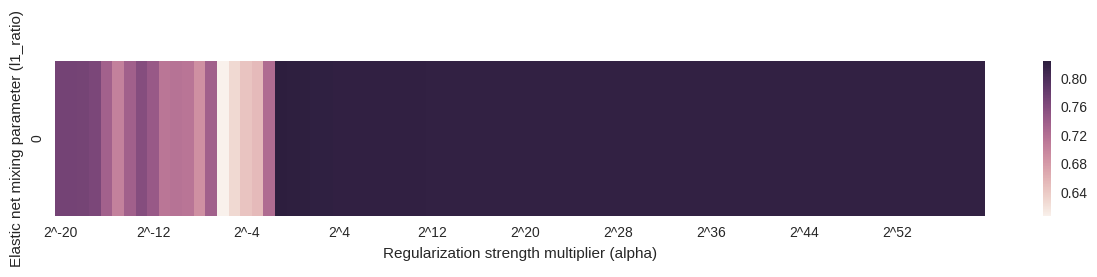

In [20]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='l1_ratio', columns='alpha')
fig, ax = plt.subplots(figsize=(15,2))

xticks = ['2^'+str(x) for x in range(-20, 60)]
keptticks = xticks[::int(len(xticks)/10)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks

ax = sns.heatmap(cv_score_mat, annot=False, fmt='.1%', xticklabels=xticks)
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [21]:
y_pred_train = cv.decision_function(X_train_scale)
y_pred_test = cv.decision_function(X_test_scale)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

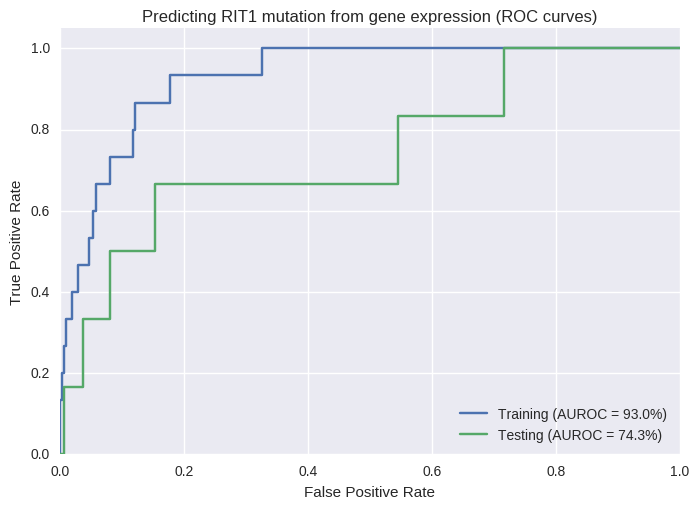

In [22]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting RIT1 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## Investigate the predictions

In [23]:
X_transformed = scale_post.transform(pca.transform(scale_pre.transform(X)))

In [24]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', cv.decision_function(X_transformed)),
    ('probability', cv.predict_proba(X_transformed)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [25]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-C5-A2LS-01,TCGA-C5-A2LS-01,0,0,1.809132,0.859257,85.9%
TCGA-55-A492-01,TCGA-55-A492-01,1,0,1.763314,0.853624,85.4%
TCGA-86-8674-01,TCGA-86-8674-01,0,0,1.743946,0.851188,85.1%
TCGA-49-4486-01,TCGA-49-4486-01,1,0,1.721305,0.848297,84.8%
TCGA-67-3770-01,TCGA-67-3770-01,0,0,1.714850,0.847464,84.7%
TCGA-FU-A3EO-01,TCGA-FU-A3EO-01,0,0,1.684363,0.843481,84.3%
TCGA-80-5608-01,TCGA-80-5608-01,0,0,1.680588,0.842982,84.3%
TCGA-55-8506-01,TCGA-55-8506-01,1,0,1.668690,0.841401,84.1%
TCGA-IR-A3LI-01,TCGA-IR-A3LI-01,0,0,1.664140,0.840793,84.1%


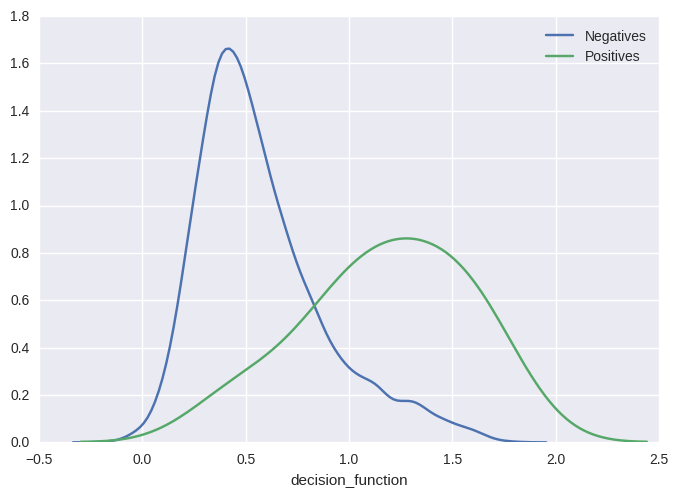

In [26]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

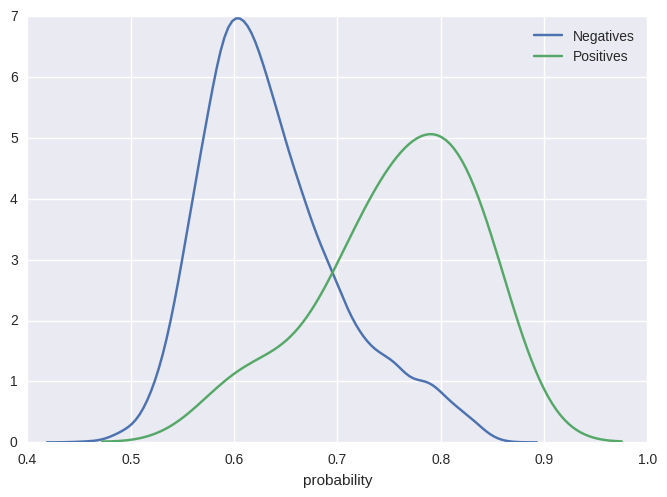

In [27]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')